In [1]:
# Librerias estandar de Python
from glob import glob
from re import sub
from os import listdir, remove, mkdir, rename, walk
from os.path import join, isdir
from warnings import simplefilter
from distutils.dir_util import copy_tree
from shutil import rmtree
import random as random

# Keras
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential, Model, clone_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.initializers import glorot_uniform

# Third party
from matplotlib import pyplot as plt
from skimage.io import imread
from tensorflow.compat.v1 import ConfigProto, Session
import matplotlib as mpl
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
sess = Session(config=ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [3]:
seed = 27912
np.random.seed(seed)

In [4]:
# Set inline graphics
%matplotlib inline

# Set the figure size for proper rendering
mpl.rcParams["figure.figsize"] = (8, 4)

# Filter the warnings
simplefilter("ignore")

In [5]:
def validation_split(path, percentage, seed):
    """Separa el conjunto de entrenamiento en
    entrenamiento y test.
    
    Las carpetas creadas son ../train y ../validation

    Parameters
    ----------
    path : str
        Directorio original del conjunto de entrenamiento

    percentage: float
        Fracción del conjunto de entrenamiento que se dedicará a
        validacion
        
    seed: int
        Semilla para garantizar reproducibilidad
    """
    
    # Copiamos el contenido a un nuevo directorio
    # (Se copia entero para garantizar reproducibilidad)
    # (Si la carpeta ya existe, se reemplaza)

    copy_tree("../input/recognition/train", "../train")

    # Intentamos eliminar la carpeta de validación y recrearla
    # (Ignoramos posibles errores)
    rmtree("../validation", ignore_errors=True)
    
    # Recreamos la carpeta 
    mkdir("../validation")
    
    # Muestreamos cada carpeta de entrenamiento por separado
    # (hacemos muestreo estratificado)
    for folder in listdir("../train"):
        
        # Creamos la carpeta correspondiente en validacion
        mkdir("../validation/" + str(folder))
        
        # Obtenemos una lista con todos los ficheros de la carpeta
        files = listdir("../train/" + str(folder))
        
        # Calculamos cuantos ficheros hay que mover
        size = int(len(files) * percentage) 
        
        # Cogemos una muestra aleatoria (usando la semilla)
        # (El tamaño dependera de la proporcion)
        random.seed(seed)
        sample = random.sample(files, size)
        
        # Movemos los ficheros elegidos de train a validation
        for file in sample:
            rename("../train/" + str(folder) + "/" + str(file), "../validation/" + str(folder) + "/" + str(file))

In [6]:
validation_split("../input/recognition/train", 0.2, seed)

In [7]:
print("Carpetas de entrenamiento:")
!ls ../train
print("Carpeta de validacion: ")
!ls ../validation
print("\nTamaño del conjunto de entrenamiento: " + str(sum([len(files) for r, d, files in walk("../train")])))
print("Tamaño del conjunto de validacion: " + str(sum([len(files) for r, d, files in walk("../validation")])))

Carpetas de entrenamiento:
0  1  2  3  4  5  6  7	8  9
Carpeta de validacion: 
0  1  2  3  4  5  6  7	8  9

Tamaño del conjunto de entrenamiento: 33604
Tamaño del conjunto de validacion: 8396


In [8]:
paths = {
    "train": "../train",
    "validation": "../validation",
    "test": "../input/recognition/test",
}

In [9]:
def visualize_training(path, n_images=10):
    """Visualize the images of the training dataset.

    Parameters
    ----------
    path : str
        The path to the training dataset.

    n_images : int, optional (default=10)
        The number of images to show for each class label.
    """
    # Extract the class labels from the
    # directory of the training dataset
    class_labels = sorted(listdir(path))
    n_class_labels = len(class_labels)
    
    # Configure the axis to plot the images
    (fig, ax) = plt.subplots(
        n_class_labels, n_images,
        sharex="col", sharey="row",
        gridspec_kw={"hspace": 0, "wspace": 0})
    
    # Set the size of the figure
    fig.set_size_inches(15, 15)
    
    # Show the specified number of
    # images for each class label
    for (row, class_label) in enumerate(class_labels):
        # Extract the filename of the images
        # (obtaining a random sample with
        # size the number of images to show)
        filenames = sorted(glob(join(path, class_label, "*.jpg")))
        filenames = np.random.choice(filenames, size=n_images, replace=False)
        # Show the selected images for this class label
        for (col, filename) in enumerate(filenames):
            # Obtain the array containing the
            # matrix associated with the image
            image = imread(filename, as_gray=True)
            # Remove the axis for the image
            ax[row, col].axis("off")
            # Show the image
            ax[row, col].imshow(image, cmap="gray", aspect="auto")

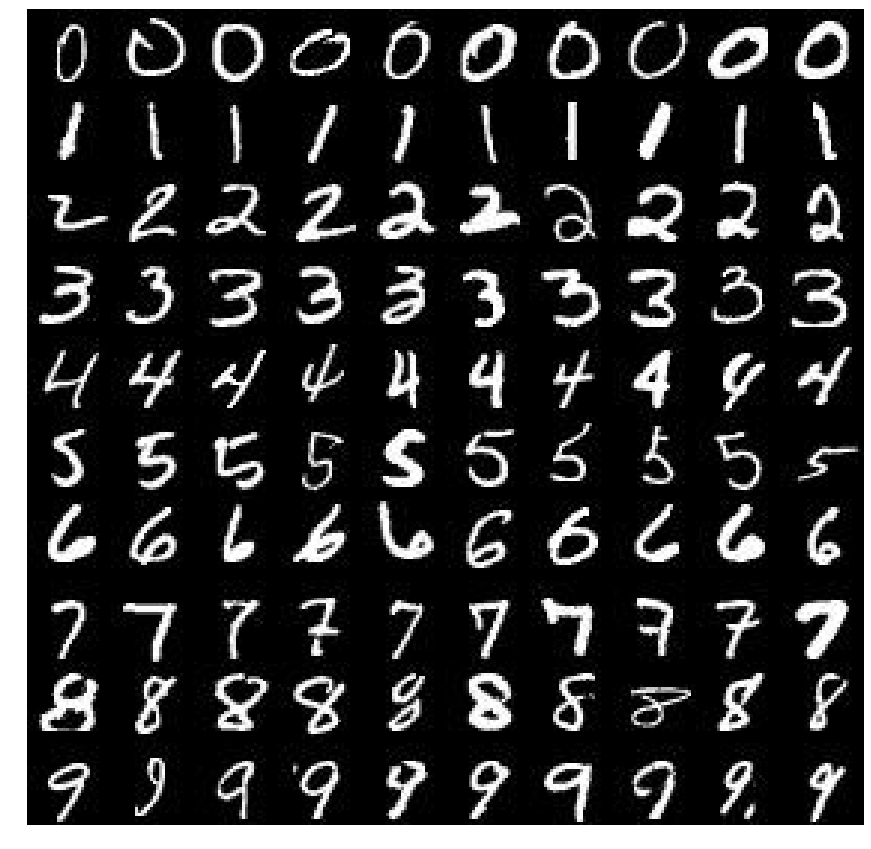

In [10]:
visualize_training(paths["train"], n_images=10)

In [11]:
# Factor de reescalado y tamaño del conjunto de validacion
factor = 1 / 255
val_size = 0.2

# Configuramos los generadores de imagenes con los hiperparametros especificados previamente
train_datagen = ImageDataGenerator(rescale=factor)
validation_datagen = ImageDataGenerator(rescale=factor)
test_datagen = ImageDataGenerator(rescale=factor)

In [12]:
def create_iterator(datagen, directory, target_size,
                    batch_size=64, shuffle=True,
                    seed=None, subset=None):
    """Create an iterator for the images in the given path.

    Parameters
    ----------
    datagen : ImageDataGenerator
        The generator of the images.

    directory : str
        Path to the target directory.

    target_size : tuple
        The dimensions to which all images found will be resized.

    batch_size : int, optional (default=64)
        Size of the batches of data

    shuffle : bool, optional (default=True)
        Whether to shuffle the data,

    seed : int, optional (default=None)
        Random seed for shuffling and transformations.

    subset : str, optional (default=None)
        Subset of data (`"training"` or `"validation") if
        `validation_split` is set in `ImageDataGenerator`.

    Returns
    -------
    iterator : DirectoryIterator
        Yields tuples of `(x, y)`, where `x` is an
        array containing a batch of images with shape
        `(batch_size, *target_size, channels)`
        and `y` is an array of corresponding labels.
    """
    # For convenience, setup the color mode
    # to RGB instead of gray-scale
    return datagen.flow_from_directory(
        directory, target_size,
        color_mode="rgb", batch_size=batch_size,
        shuffle=shuffle, seed=seed, subset=subset)

In [13]:
# Define the size of the images (they
# will be rescaled to this size)
img_width = img_height = 128
target_size = (img_width, img_height)

# Configure the iterator from the generator of the datasets
train_generator = create_iterator(train_datagen, paths["train"], target_size, seed=seed)
val_generator = create_iterator(validation_datagen, paths["validation"], target_size, seed=seed)
test_generator = create_iterator(test_datagen, paths["test"], target_size, shuffle=False, seed=seed)

Found 33604 images belonging to 10 classes.
Found 8396 images belonging to 10 classes.
Found 28000 images belonging to 1 classes.


In [14]:
def compile_model(model,
                  learning_rate=1e-3,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"]):
    """Configure the model with respect to the hyperparameters.

    Parameters
    ----------
    model : object
        The model to configure.

    learning_rate : float
        The learning rate.

    loss : str
        The objective function.

    metrics : list
        List of metrics to be evaluated by
        the model during training and testing.

    Returns
    -------
    configured_model : object
        The model configured for training.
    """
    model.compile(optimizer=Adam(lr=learning_rate), loss=loss, metrics=metrics)

In [15]:
def set_layers(base_model):
    """Set the layers of the base model to non-trainable.

    Parameters
    ----------
    base_model : object
        The pre-trained model.
    """
    # Set all the layers of the base model to
    # non-trainable (by default, all are trainable)
    for layer in base_model.layers:
        layer.trainable = False

In [16]:
# Define the parameters needed by the NN
classes = train_generator.class_indices
n_classes = len(classes)

In [17]:
# Parametros a usar
dropout_rate = 0.2

# El hiperparámetro data_format indica
# en que dimensión está el canal
flatten_layer = Flatten(data_format="channels_last",
                        input_shape=(*target_size, 3))

# Capas ocultas (con ReLU y dropout)
hidden_layer1 = Dense(64, 
                      activation="relu",
                      kernel_initializer=glorot_uniform(seed=seed))
dropout_layer1 = Dropout(dropout_rate, seed=seed)
hidden_layer2 = Dense(64, 
                      activation="relu",
                      kernel_initializer=glorot_uniform(seed=seed))
dropout_layer2 = Dropout(dropout_rate, seed=seed)

# Capa de salida (con softmax)
output_layer = Dense(n_classes, 
                     activation="softmax",
                     kernel_initializer=glorot_uniform(seed=seed))

# Se añaden las capas al modelo
nn_layers = [flatten_layer, hidden_layer1, dropout_layer1, hidden_layer2, dropout_layer2, output_layer]
nn_model = Sequential(nn_layers)

# Resumen del modelo
nn_model.summary(line_length=50)

Model: "sequential_1"
__________________________________________________
Layer (type)          Output Shape        Param # 
flatten_1 (Flatten)   (None, 49152)       0       
__________________________________________________
dense_1 (Dense)       (None, 64)          3145792 
__________________________________________________
dropout_1 (Dropout)   (None, 64)          0       
__________________________________________________
dense_2 (Dense)       (None, 64)          4160    
__________________________________________________
dropout_2 (Dropout)   (None, 64)          0       
__________________________________________________
dense_3 (Dense)       (None, 10)          650     
Total params: 3,150,602
Trainable params: 3,150,602
Non-trainable params: 0
__________________________________________________


In [18]:
compile_model(nn_model)

In [19]:
# Parametros a usar
dropout_rate = 0.2

# Añadimos dos capas convolucionales de 32 filtros
# (tamaño 3x3) usando ReLU como funcion de activacion.
# Se usa una capa de max-pooling con tamaño de ventana 3.
conv_layer1 = Conv2D(32, 3, 
                     activation="relu",
                     kernel_initializer=glorot_uniform(seed=seed),
                     input_shape=(*target_size, 3))
conv_layer2 = Conv2D(32, 3, 
                     activation="relu",
                     kernel_initializer=glorot_uniform(seed=seed))
pool_layer1 = MaxPooling2D(pool_size=3)

# Añadimos dos capas convolucionales de 64 filtros
# (tamaño 3x3) usando ReLU como funcion de activacion.
# Se usa una capa de max-pooling con tamaño de ventana 2.
conv_layer3 = Conv2D(64, 3, 
                     activation="relu",
                     kernel_initializer=glorot_uniform(seed=seed))
conv_layer4 = Conv2D(64, 3, 
                     activation="relu",
                     kernel_initializer=glorot_uniform(seed=seed))
pool_layer2 = MaxPooling2D(pool_size=2)

# Se extrae el vector con todas las características para
# pasarlo a la capa oculta.
flatten_layer = Flatten(data_format="channels_last")

# Se añade una capa oculta totalmente conectada
# con 512 neuronas, usando ReLU como activación.
# También se aplica dropout.
hidden_layer = Dense(512, 
                     activation="relu",
                     kernel_initializer=glorot_uniform(seed=seed))
dropout_layer = Dropout(dropout_rate, seed=seed)

# Se añade la capa de salida con diez valores (número de posibles salidas)
# utilizando soft-max como función de activación.
output_layer = Dense(n_classes, 
                     activation="softmax",
                     kernel_initializer=glorot_uniform(seed=seed))

# Se definen las capas del modelo CNN
cnn_layers = [
    conv_layer1, conv_layer2, pool_layer1,
    conv_layer3, conv_layer4, pool_layer2,
    flatten_layer, hidden_layer, 
    dropout_layer, output_layer
]

# Se construye el modelo CNN
cnn_model = Sequential(cnn_layers)

# Descripción del modelo
cnn_model.summary(line_length=80)

Model: "sequential_2"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_1 (Conv2D)                   (None, 126, 126, 32)            896         
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 124, 124, 32)            9248        
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 41, 41, 32)              0           
________________________________________________________________________________
conv2d_3 (Conv2D)                   (None, 39, 39, 64)              18496       
________________________________________________________________________________
conv2d_4 (Conv2D)                   (None, 37, 37, 64)              36928       
________________________________________________________________________________
max_po

In [20]:
compile_model(cnn_model)

In [21]:
def train_model(model, train_generator, val_generator, callbacks=[], epochs=5):
    """Train the model using the given training dataset.

    Parameters
    ----------
    model : object
        The model to train.

    train : object
        The iterator with the training dataset.

    val : object
        The generator with the validation dataset.

    epochs : int, optional (default=5)
         Number of epochs to train the model.

    Returns
    -------
    history : dict
        Record of training loss values and metrics values
        at successive epochs, as well as validation loss
        values and validation metrics values.
    """
    return model.fit_generator(
        train_generator, validation_data=val_generator, epochs=epochs, callbacks = callbacks)

In [22]:
#Si la carpeta no existe, creamos una carpeta para guardar los modelos
if not isdir("../models"):
    mkdir("../models")

# ModelCheckpoints del perceptron multicapa
checkpointer_acc_nn = ModelCheckpoint(filepath='../models/nn_acc_weights.hdf5',
                                      monitor='val_accuracy',
                                      save_best_only=True)
checkpointer_loss_nn = ModelCheckpoint(filepath='../models/nn_loss_weights.hdf5',
                                      monitor='val_loss',
                                      save_best_only=True)

# ModelCheckpoints de la red convolucional
checkpointer_acc_cnn = ModelCheckpoint(filepath='../models/cnn_acc_weights.hdf5',
                                       monitor='val_accuracy',
                                       save_best_only=True)
checkpointer_loss_cnn = ModelCheckpoint(filepath='../models/cnn_loss_weights.hdf5',
                                       monitor='val_loss',
                                       save_best_only=True)

# ModelCheckpoints de la red entrenada con Transfer Learning
checkpointer_acc_tf = ModelCheckpoint(filepath='../models/tf_acc_weights.hdf5',
                                      monitor='val_accuracy',
                                      save_best_only=True)
checkpointer_loss_tf = ModelCheckpoint(filepath='../models/tf_loss_weights.hdf5',
                                      monitor='val_loss',
                                      save_best_only=True)

# Creamos los callbacks de los modelos
callbacks_nn = [checkpointer_acc_nn, checkpointer_loss_nn]
callbacks_cnn = [checkpointer_acc_cnn, checkpointer_loss_cnn]
callbacks_tf = [checkpointer_acc_tf, checkpointer_loss_tf]

In [23]:
def plot_history(history):
    """Plot the evolution of the loss function and the accuracy with
    respect to the training dataset and the validation dataset.
    
    Parameters
    ----------
    history : dict
        Dictionary recording training loss values
        and metrics values at successive epochs.
    """
    # Initialize the subplots for the loss and the accuracy
    (fig, ax) = plt.subplots(1, 2)
    
    # Set the size of the figure
    fig.set_size_inches((16, 4))

    # Set the title of the plots
    ax[0].set_title("Model loss")
    ax[1].set_title("Model accuracy")
    
    # Set the x-axis and y-axis labels
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    
    # Plot the history of the training
    # and the validation datasets
    ax[0].plot(history.history["loss"])
    ax[0].plot(history.history["val_loss"])
    ax[1].plot(history.history["accuracy"])
    ax[1].plot(history.history["val_accuracy"])
    
    # Set the legend of the training
    # and the validation datasets
    ax[0].legend(["Train", "Validation"], loc="upper right")
    ax[1].legend(["Train", "Validation"], loc="upper right")

In [24]:
def get_results(model, generator):
    """
    Devuelve los valores de loss y accuracy respecto a
    un generador de datos indicado
    
    Parameters
    ----------
    model : Model
        Modelo entrenado sobre el que evaluar
        
    generator: Iterator
        Iterador del conjunto de datos sobre el que
        se evaluará
    
    Outputs
    -------
    
    Loss y Accuracy del modelo respecto a los datos
    en una Series [loss, accuracy]
    """
    
    return model.evaluate_generator(generator)

In [25]:
nn_history = train_model(nn_model, train_generator, val_generator, callbacks_nn)

Epoch 1/5
526/526 [==============================] - 22s 41ms/step - loss: 0.6945 - accuracy: 0.7884 - val_loss: 0.0799 - val_accuracy: 0.9117
Epoch 2/5
526/526 [==============================] - 20s 38ms/step - loss: 0.4568 - accuracy: 0.8667 - val_loss: 0.4951 - val_accuracy: 0.9306
Epoch 3/5
526/526 [==============================] - 20s 38ms/step - loss: 0.3746 - accuracy: 0.8871 - val_loss: 0.0320 - val_accuracy: 0.9376
Epoch 4/5
526/526 [==============================] - 20s 39ms/step - loss: 0.3340 - accuracy: 0.9011 - val_loss: 0.1354 - val_accuracy: 0.9391
Epoch 5/5
526/526 [==============================] - 20s 38ms/step - loss: 0.3077 - accuracy: 0.9096 - val_loss: 0.1009 - val_accuracy: 0.9409


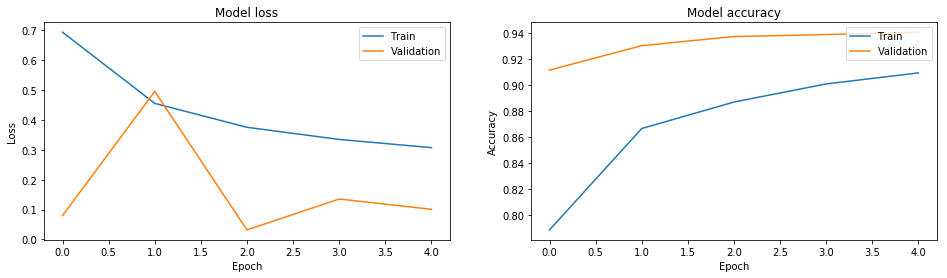

In [26]:
plot_history(nn_history)

In [27]:
# Modelo de val_accuracy
nn_acc_model = clone_model(nn_model.model)
# Nota: es necesario compilar el modelo despues de clonarlo
compile_model(nn_acc_model)
nn_acc_model.load_weights("../models/nn_acc_weights.hdf5")

# Modelo de val_loss
nn_loss_model = clone_model(nn_model.model)
compile_model(nn_loss_model)
nn_loss_model.load_weights("../models/nn_loss_weights.hdf5")

In [28]:
# Modelo de val_accuracy
nn_acc_results = get_results(nn_acc_model, val_generator)
print("- val_accuracy -")
print("Loss del modelo: " + str(nn_acc_results[0]))
print("Accuracy del modelo: " + str(nn_acc_results[1]))

# Modelo de val_loss
nn_loss_results = get_results(nn_loss_model, val_generator)
print("\n- val_loss -")
print("Loss del modelo: " + str(nn_loss_results[0]))
print("Accuracy del modelo: " + str(nn_loss_results[1]))

- val_accuracy -
Loss del modelo: 0.18745429813861847
Accuracy del modelo: 0.9409242272377014

- val_loss -
Loss del modelo: 0.20546919107437134
Accuracy del modelo: 0.9375893473625183


In [29]:
cnn_history = train_model(cnn_model, train_generator, val_generator, callbacks_cnn)

Epoch 1/5
526/526 [==============================] - 28s 54ms/step - loss: 0.1548 - accuracy: 0.9524 - val_loss: 0.0194 - val_accuracy: 0.9789
Epoch 2/5
526/526 [==============================] - 25s 47ms/step - loss: 0.0487 - accuracy: 0.9843 - val_loss: 0.0450 - val_accuracy: 0.9820
Epoch 3/5
526/526 [==============================] - 24s 46ms/step - loss: 0.0268 - accuracy: 0.9908 - val_loss: 0.5373 - val_accuracy: 0.9871
Epoch 4/5
526/526 [==============================] - 26s 49ms/step - loss: 0.0177 - accuracy: 0.9944 - val_loss: 4.3506e-04 - val_accuracy: 0.9856
Epoch 5/5
526/526 [==============================] - 24s 46ms/step - loss: 0.0140 - accuracy: 0.9953 - val_loss: 0.3622 - val_accuracy: 0.9832


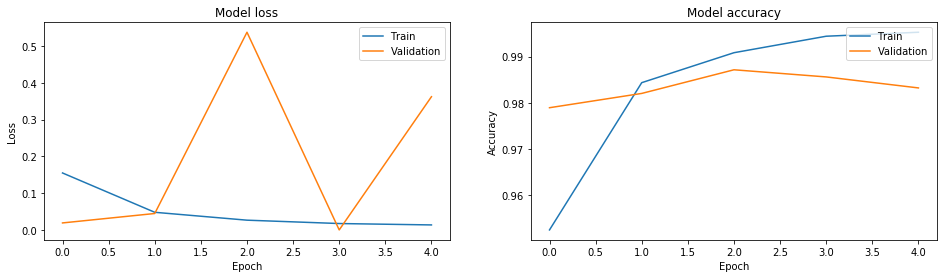

In [30]:
plot_history(cnn_history)

In [31]:
# Modelo de val_accuracy
cnn_acc_model = clone_model(cnn_model.model)
compile_model(cnn_acc_model)
cnn_acc_model.load_weights("../models/cnn_acc_weights.hdf5")

# Modelo de val_loss
cnn_loss_model = clone_model(cnn_model.model)
compile_model(cnn_loss_model)
cnn_loss_model.load_weights("../models/cnn_loss_weights.hdf5")

In [32]:
# Modelo de val_accuracy
cnn_acc_results = get_results(cnn_acc_model, val_generator)
print("- val_accuracy -")
print("Loss del modelo: " + str(cnn_acc_results[0]))
print("Accuracy del modelo: " + str(cnn_acc_results[1]))

# Modelo de val_loss
cnn_loss_results = get_results(cnn_loss_model, val_generator)
print("\n- val_loss -")
print("Loss del modelo: " + str(cnn_loss_results[0]))
print("Accuracy del modelo: " + str(cnn_loss_results[1]))

- val_accuracy -
Loss del modelo: 0.7052167057991028
Accuracy del modelo: 0.987136721611023

- val_loss -
Loss del modelo: 0.07943079620599747
Accuracy del modelo: 0.9855883717536926


In [33]:
def predict_classes(model, test_generator):
    """Obtain the predicted classes of the model over the test dataset.

    Parameters
    ----------
    model : object
        The trained model.

    test : object
        The iterator with the test dataset.

    Returns
    -------
    predictions : np.ndarray
        The predicted classes.
    """
    return model.predict_generator(test_generator).argmax(axis=-1)

In [34]:
# Define the regular expression to
# remove the strings from the filenames
remove_characters = lambda filename: int(sub("[^0-9]", "", filename))

# Obtain the order of the predicted and the true samples
pred_idx = list(map(remove_characters, test_generator.filenames))
true_idx = np.argsort(pred_idx)

In [35]:
# Perceptron multicapa

# val_accuracy
nn_acc_predictions = predict_classes(nn_acc_model, test_generator)
nn_acc_predictions = nn_acc_predictions[true_idx]

# val_loss
nn_loss_predictions = predict_classes(nn_loss_model, test_generator)
nn_loss_predictions = nn_loss_predictions[true_idx]

In [36]:
# Red convolucional

# val_accuracy
cnn_acc_predictions = predict_classes(cnn_acc_model, test_generator)
cnn_acc_predictions = cnn_acc_predictions[true_idx]

# val_loss
cnn_loss_predictions = predict_classes(cnn_loss_model, test_generator)
cnn_loss_predictions = cnn_loss_predictions[true_idx]

In [37]:
# Obtain the identifier of the samples
samples = np.arange(len(test_generator.filenames)) + 1

In [38]:
def visualize_test(predictions, path, seed, n_images=15):
    """Visualize the predictions of
    the model over the test dataset.

    Parameters
    ----------
    predictions : np.ndarray
        The predictions of the model over the test dataset.

    path : str
        The path to the images of the test dataset.

    n_images : int, optional (default=15)
        The number of images to show.
    """
    # Obtain the number of samples from the input arrays
    n_samples = len(predictions)

    # Configure the axis to plot the images
    (fig, ax) = plt.subplots(
        1, n_images,
        sharex="col", sharey="row",
        gridspec_kw={"hspace": 0, "wspace": 0})

    # Set the size of the figure
    fig.set_size_inches(n_images, 1.5)
    
    # Apply seed and obtain the random samples to plot
    np.random.seed(seed)
    idx = np.random.choice(n_samples, size=n_images, replace=False)

    # Extract the filename of the images
    filenames = sorted(glob(join(path, "*.jpg")))

    # Show the selected images
    for (col, index) in enumerate(idx):
        # Obtain the array containing the
        # matrix associated with the image
        image = imread(filenames[true_idx[index]], as_gray=True)
        # Set the title for the image
        ax[col].set_title(predictions[index])
        # Remove the axis for the image
        ax[col].axis("off")
        # Show the image
        ax[col].imshow(image, cmap="gray", aspect="auto")

In [39]:
# Obtain the path to the test data
test_path = join(paths["test"], "unknown")

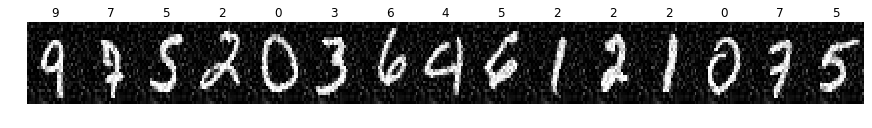

In [40]:
visualize_test(nn_acc_predictions, test_path, seed)

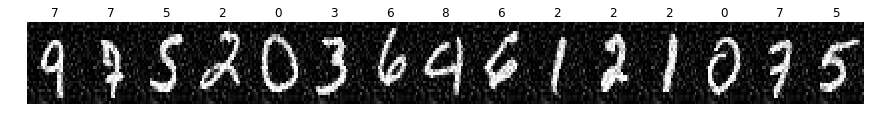

In [41]:
visualize_test(nn_loss_predictions, test_path, seed)

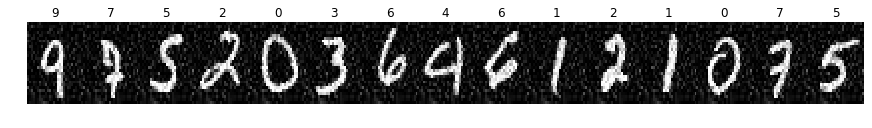

In [42]:
visualize_test(cnn_acc_predictions, test_path, seed)

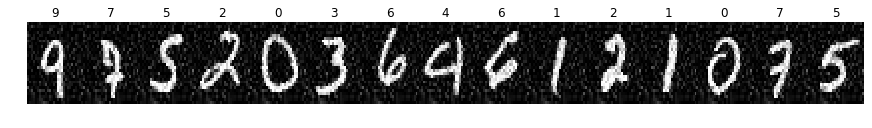

In [43]:
visualize_test(cnn_loss_predictions, test_path, seed)